# (02) Fit neurons -- Linear

**Motivation**: Fit linear models to neurons. Namely, the following models:
- ```sklearn.linear_model.PoissonRegressor```
- ```sklearn.linear_model.Ridge```
- ```sklearn.linear_model.Lasso```

In this update we will focus on one of the experiments that has repeat data: **```expt=clu090```**.

<br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-MTMST/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-MTMST/figs')
tmp_dir = os.path.join(git_dir, 'jb-MTMST/tmp')

# GitHub
sys.path.insert(0, os.path.join(git_dir, '_MTMST'))
from model.train_vae import TrainerVAE, ConfigTrain
from model.vae2d import VAE, ConfigVAE
from analysis.opticflow import *
from figures.fighelper import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from tqdm.notebook import tqdm
from rich.jupyter import print
%matplotlib inline
set_style()

In [2]:
from model.dataset import setup_repeat_data, setup_supervised_data
from analysis.linear import *

cfg = ConfigVAE(save=False)
file = h5py.File(cfg.h_file, 'r')

In [3]:
expt = 'clu090'
grp = file[expt]

In [4]:
hf_kws = {
    'size': 19,
    'sres': 1,
    'radius': 6,
}
hf = HyperFlow(
    params=np.array(grp['hyperflow'])[:, 2:],
    center=np.array(grp['hyperflow'])[:, :2],
    **hf_kws,
)
stim = hf.compute_hyperflow()
spks = np.array(grp['spks'], dtype=float)
good = ~np.array(grp['badspks'])
good = np.where(good)[0]

lags = 16
src, tgt = setup_supervised_data(lags, good, stim, spks)
stim_r, spks_r, intvl = setup_repeat_data(grp, lags, hf_kws=hf_kws)

model_kws = {
    'category': '',
    'alphas': None,
    'seed': cfg.seed,
    'verbose': True,
    'n_folds': 5,
}

i = 0
kws = {
    'x': src,
    'y': tgt[:, i],
    'x_tst': stim_r,
    'y_tst': np.nanmean(spks_r[i], 0),
    **model_kws,
}

## GLM (PoissonRegressor)

In [5]:
%%time

kws['category'] = 'PoissonRegressor'
kws['alphas'] = [0.1, 0.5, 1, 1.5, 10]
glm = LinearModel(**kws).fit()

Category: 'PoissonRegressor', default params:
{'alpha': 1.0, 'fit_intercept': True, 'max_iter': 100, 'tol': 0.0001, 'warm_start': False, 
'verbose': 0}

CPU times: user 1h 6min 17s, sys: 26.2 s, total: 1h 6min 43s
Wall time: 3min 3s


In [6]:
glm.r2_tst

{0.1: 51.2099082369531,
 0.5: 56.76575276052398,
 1: 54.62182271853129,
 1.5: 52.18168376413473,
 10: 25.042087179302452}

In [7]:
glm.r_tst

{0.1: 0.7497312142078411,
 0.5: 0.7683677210994397,
 1: 0.7635045613417343,
 1.5: 0.7595796368598915,
 10: 0.7250668817542121}

In [8]:
glm.df

,nnll,r2,r
alpha,,,
0.1,0.217738,50.705696,0.322910
0.5,0.194612,56.637341,0.307487
1.0,0.181544,54.555273,0.301099
1.5,0.172039,52.130891,0.297452
10.0,0.098339,25.035633,0.277896


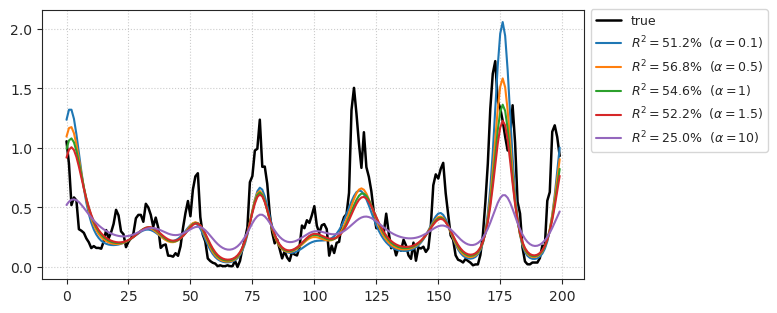

In [9]:
glm.show_pred();

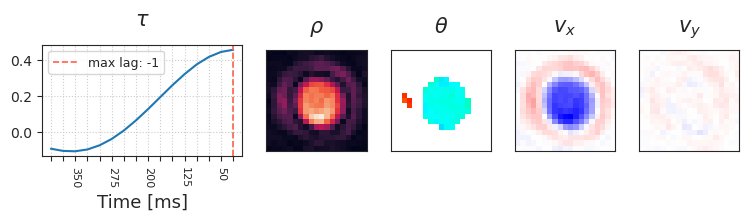

In [11]:
glm.kers[1.5].show();

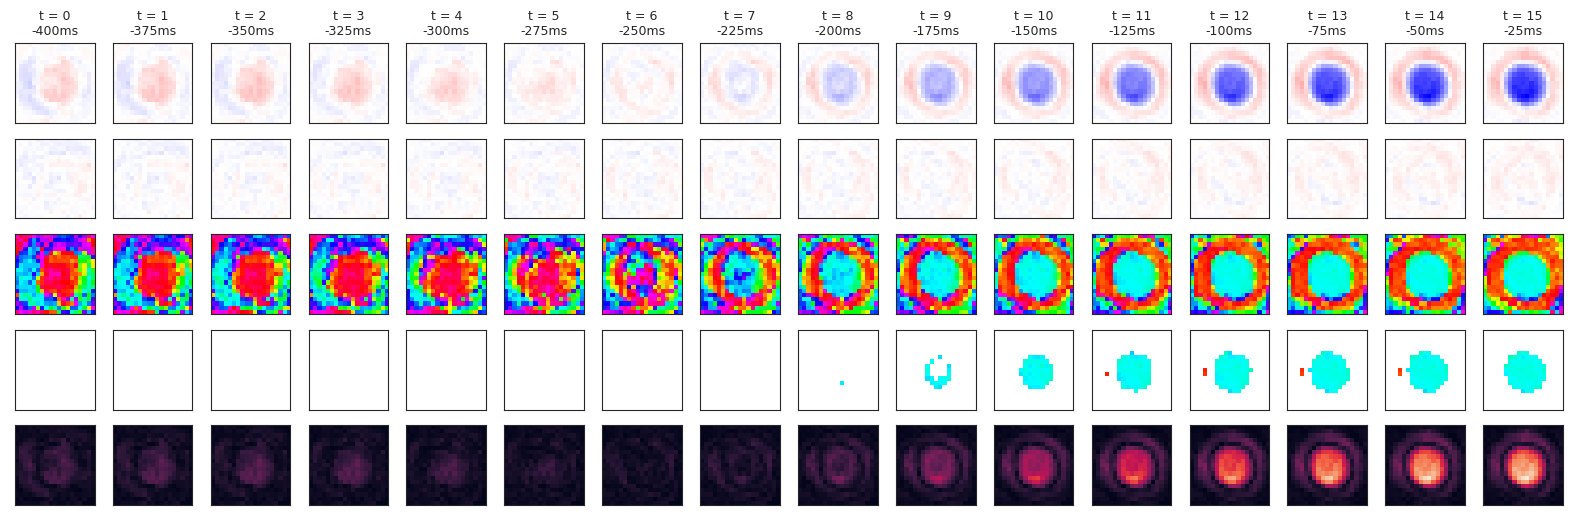

In [12]:
glm.kers[1.5].show_full();

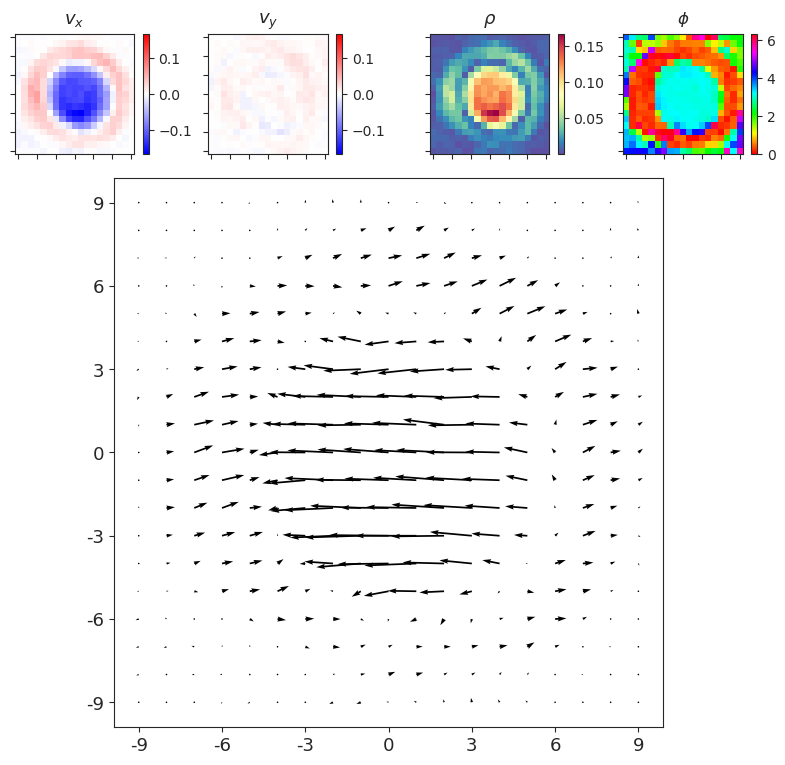

In [13]:
tker, sker = glm.kers[1.5].get_kers(0)
_ = show_opticflow_full(sker[0], scale=1.5)

## Ridge

In [14]:
%%time

kws['category'] = 'Ridge'
kws['alphas'] = [8e3, 1e4, 5e4, 1e5, 5e5, 1e6]
ridge = LinearModel(**kws).fit()

Category: 'Ridge', default params:
{'alpha': 1.0, 'fit_intercept': True, 'normalize': False, 'copy_X': True, 'max_iter': None, 
'tol': 0.001, 'solver': 'auto', 'random_state': 0}

CPU times: user 2h 34min 7s, sys: 31min 47s, total: 3h 5min 54s
Wall time: 10min 30s


In [15]:
ridge.r2_tst

{8000.0: 60.13619902485547,
 10000.0: 60.30432301213868,
 50000.0: 57.36557914995072,
 100000.0: 54.21357454571194,
 500000.0: 41.14870807702563,
 1000000.0: 31.86802897816824}

In [16]:
ridge.r_tst

{8000.0: 0.8149438019053743,
 10000.0: 0.8167578147553122,
 50000.0: 0.8135974317359506,
 100000.0: 0.8051058962858357,
 500000.0: 0.7685703429057043,
 1000000.0: 0.7473781917555641}

In [17]:
ridge.df

,nnll,r2,r
alpha,,,
8000.0,0.068726,60.077944,0.326825
10000.0,0.072905,60.110587,0.324394
50000.0,0.079701,56.377129,0.306528
100000.0,0.092411,52.889558,0.298495
500000.0,0.130421,38.392255,0.280253
1000000.0,0.112197,28.468447,0.273092


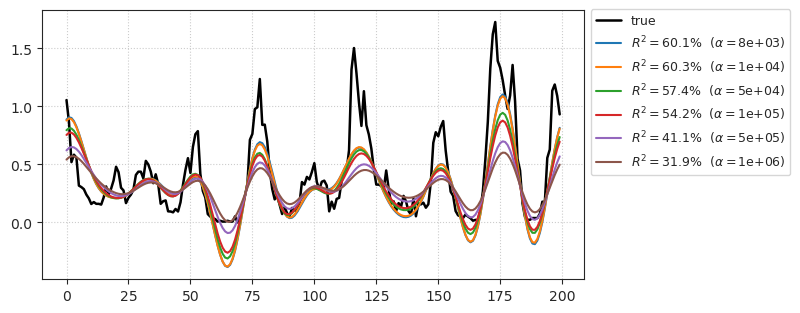

In [18]:
ridge.show_pred();

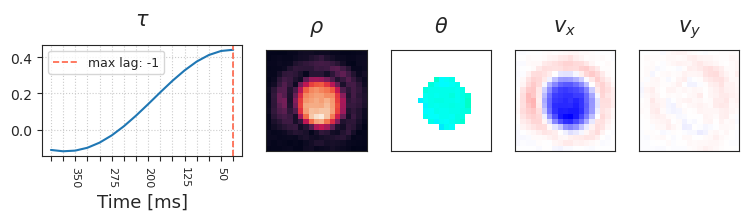

In [19]:
ridge.kers[5e5].show();

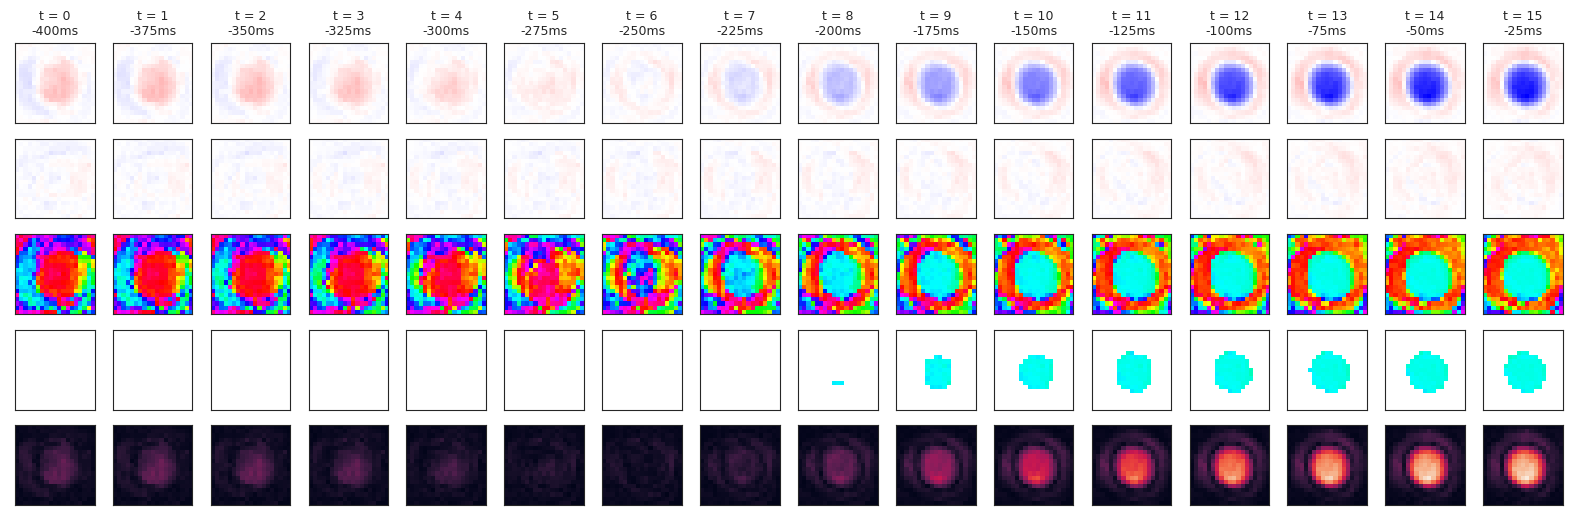

In [20]:
ridge.kers[5e5].show_full();

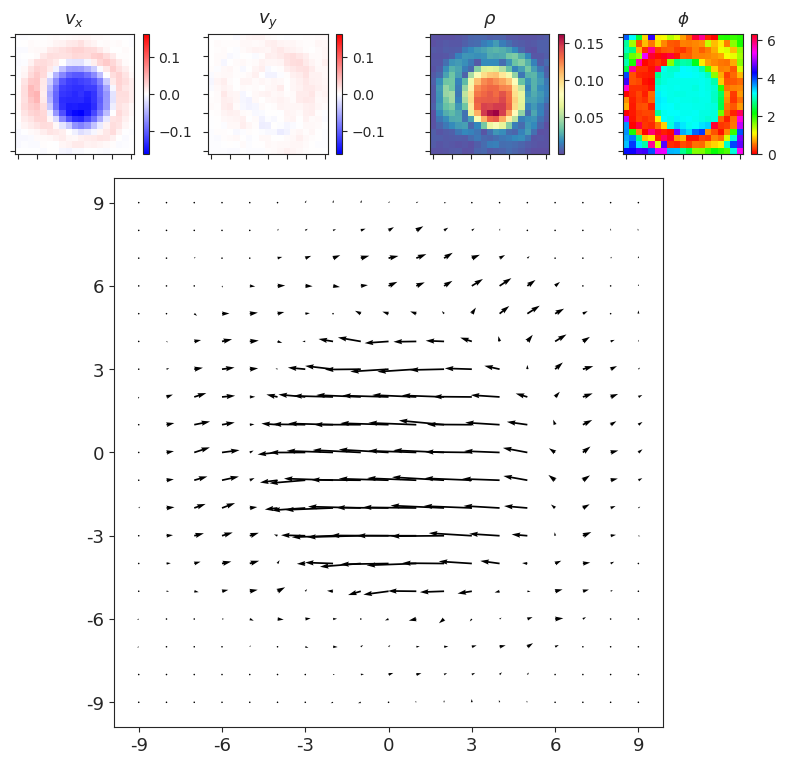

In [21]:
tker, sker = ridge.kers[5e5].get_kers(0)
_ = show_opticflow_full(sker[0], scale=1.5)

## Lasso

In [18]:
%%time

kws['category'] = 'Lasso'
kws['alphas'] = [0.0005, 0.001, 0.01]
lasso = LinearModel(**kws).fit()

Category: 'Lasso', default params:
{'alpha': 1.0, 'fit_intercept': True, 'normalize': False, 'precompute': False, 'copy_X': 
True, 'max_iter': 1000, 'tol': 0.0001, 'warm_start': False, 'positive': False, 
'random_state': 0, 'selection': 'cyclic'}

/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.9232940486544976, tolerance: 2.2894204776964666
  model = cd_fast.enet_coordinate_descent(
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.270430088332432, tolerance: 1.8189612462075944
  model = cd_fast.enet_coordinate_descent(
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.309374020444011, tolerance: 1.8430732721965568
  model = cd_fast.enet_coordinate_descent(
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desce

CPU times: user 14h 20min 11s, sys: 33.2 s, total: 14h 20min 44s
Wall time: 39min 57s


In [19]:
lasso.r2_tst

{0.0005: 57.55575527586626, 0.001: 57.67281667134164, 0.01: 42.19323567344274}

In [20]:
lasso.r_tst

{0.0005: 0.800161723282006,
 0.001: 0.8171069858859843,
 0.01: 0.7815425575478869}

In [21]:
lasso.df

,nnll,r2,r
alpha,,,
0.0005,0.057383,56.280243,0.326312
0.0010,0.049368,57.503570,0.312560
0.0100,0.090510,42.208132,0.277509


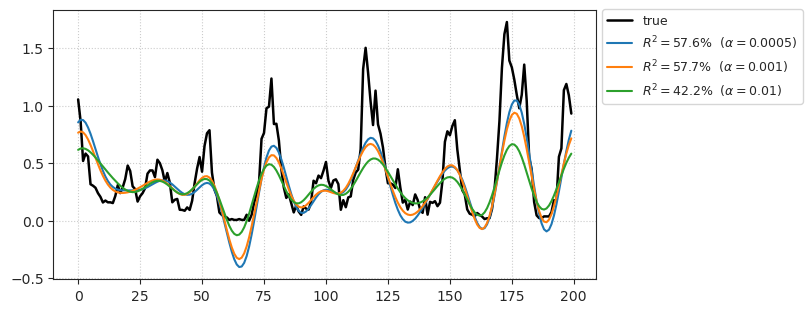

In [22]:
lasso.show_pred();

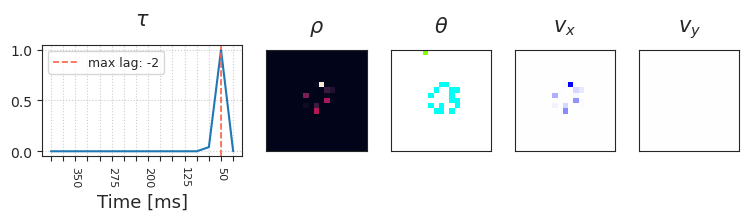

In [29]:
lasso.kers[0.01].show();